In [2]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure, color, io

In [4]:
from keras.models import load_model
from keras.metrics import MeanIoU
new_model = load_model(r"D:\Deep Learning\Unet_+_WaterShed\mitochondria_test.hdf5", compile=False)

new_model.compile('adam', 'binary_crossentropy', metrics=['accuracy']) # u need to compile the newly loaded model, othwerwise u would not be able to evaluate or train or predict;

1/1 [==============================] - 0s 120ms/step


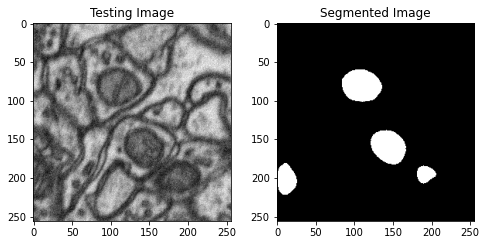

In [10]:
test_img = cv2.imread(r"D:\Deep Learning\U Net Basics\Mitochrondria Segmentation\Mito_Data\patches_train\image\image_997.tif", 0)
test_img_norm = np.expand_dims(normalize(np.array(test_img), axis=1),2)
test_img_norm = test_img_norm[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)

segmented = (new_model.predict(test_img_input)[0,:,:,0] > 0.6).astype(np.uint8)
# threshold value = .6 --> model is doing a agreat job, nicely finding boundaries between mitocondrias;

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Segmented Image')
plt.imshow(segmented, cmap='gray')
plt.show()

1/1 [==============================] - 0s 124ms/step


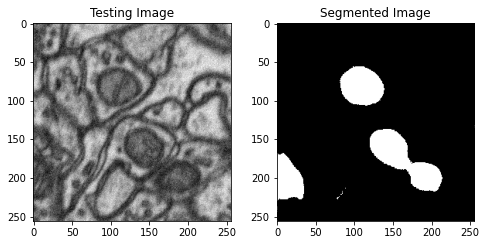

In [44]:
test_img = cv2.imread(r"D:\Deep Learning\U Net Basics\Mitochrondria Segmentation\Mito_Data\patches_train\image\image_997.tif", 0)
test_img_norm = np.expand_dims(normalize(np.array(test_img), axis=1),2)
test_img_norm = test_img_norm[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img_norm, 0)

segmented = (new_model.predict(test_img_input)[0,:,:,0] > 0.31).astype(np.uint8)
# threshold value = .05 --> model is not performing well, can't find the mitocondria borders nicely; thats why i need watershed algo to instance segmentation;

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(222)
plt.title('Segmented Image')
plt.imshow(segmented, cmap='gray')
plt.show()

plt.imsave(r"D:\Deep Learning\Unet_+_WaterShed\results\output_crappy.jpg", segmented, cmap = 'gray')

In [45]:
img = cv2.imread(r"D:\Deep Learning\Unet_+_WaterShed\results\output_crappy.jpg") # reading the image as color iamge(3 channel image);
img_grey = img[:, :, 0] # grey image as 0th channel, which is grey;
# plt.imshow(img_grey, cmap = 'gray')

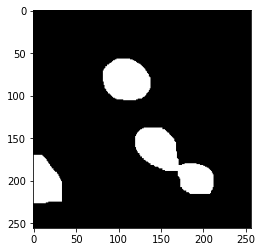

In [46]:
# threshold image to binary using OTSU, aLl thresholded pixels will be set to 255;
ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 6)
plt.imshow(opening  , cmap = 'gray') # image got cleaned;

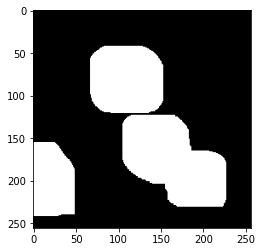

In [47]:
sure_bg = cv2.dilate(opening,kernel,iterations=15) # defining what is my "i am that this is my background";
plt.imshow(sure_bg  , cmap = 'gray') # all the black is sure backgound;

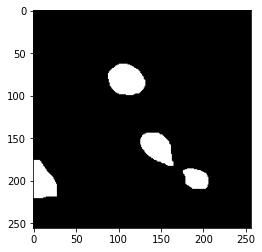

In [48]:
# now i want sure foregound(mitocondria), but as mitocondria is not of an perfect geometric shape, and i cant find a perfect center and strech from that, i need distance-transform;
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

ret2, sure_fg = cv2.threshold(dist_transform, 0.25*dist_transform.max(),255,0) # 0.25 --> increasing this value, makes the foreground much narrower;
plt.imshow(sure_fg  , cmap = 'gray') 

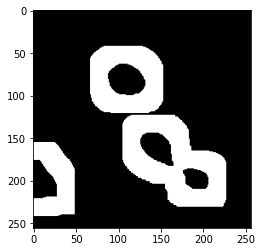

In [49]:
# now, i have sure-background, and sure-foreground; to find the ambigous area, i need top subtract both of these;
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.imshow(unknown, cmap = 'gray') # border areas, where i need watershed help;

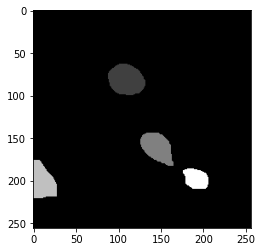

In [50]:
# finding markers
ret3, markers = cv2.connectedComponents(sure_fg)
plt.imshow(markers, cmap = 'gray') # marking all the copnnected componenets and marking it as 0(background = black), 1(mito1 = brightest white), 2(mito2 = pale white), 3(mito3 = palest white)

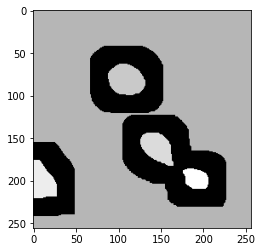

In [51]:
# problem is rightnow is that the entire background pixels(black) is given value 0, means watershed considers this region as unknown, which will create a problem, so add 10 to all labels so that sure background is not 0, but 10;
markers = markers+10

# pixel value 0 --> means watershed gonna work in here, but i dont want that, as this is sure background place; only place where i want the watershed to work is unknown areas(border areas), so that only i need to make it pixel value = 0;
markers[unknown == 255] = 0 # make unknown from markers as 0;

plt.imshow(markers, cmap = 'gray') # 0--> borders(watershed needed), 1--> bg, 2,3,4,5--> fg;

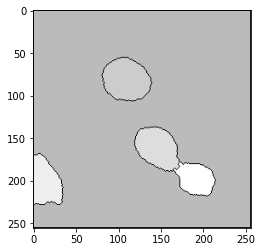

In [52]:
# doing for watershed;
markers = cv2.watershed(img, markers)
plt.imshow(markers, cmap = 'gray') # already semantic segmentation done;
# border value retuend by watersehd as -1;

In [53]:
# color boundaries in yellow;

img[markers == -1] = [0,255,255]  # making -1 areas(borders) as colored;

img2 = color.label2rgb(markers, bg_label=0)

cv2.imshow('Overlay on original image', img)
cv2.imshow('Colored Grains', img2)
cv2.waitKey(0)

-1

In [54]:
# now, extract properties of detected cells; regionprops function in skimage measure module calculates useful parameters for each object.

props = measure.regionprops_table(markers, intensity_image=img_grey, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])  
import pandas as pd
df = pd.DataFrame(props)
df = df[df.mean_intensity > 100]  #Remove background or other regions that may be counted as objects

print(df.head())


   label    area  equivalent_diameter  mean_intensity  solidity
1     11  2171.0            52.575689      254.125749  0.964032
2     12  1899.0            49.171962      253.718273  0.946660
3     13  1515.0            43.919903      254.085809  0.951036
4     14  1303.0            40.731206      253.403684  0.915671
